In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras import datasets, layers, models
import numpy as np
import seaborn as sns


## Regression

In [2]:
d=load_boston()
d.keys()

C:\Users\quilo\.conda\envs\DataScience\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California hou

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

In [3]:
X=d['data']
y=d['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [4]:
model=Sequential()
model.add(Dense(100,input_dim=X_train.shape[1],activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(1))
model.compile(loss='mae',optimizer='adam')
model.fit(X_train,y_train,epochs=1000, batch_size=32, verbose=0)
f=model.predict(X_test).flatten()

In [6]:
alpha=0.05
N=len(y_test)
q_yhat=np.quantile(np.abs(y_test-f),np.ceil((N+1)*(1-alpha))/N)

In [7]:
def calculate_coverage(lower_bound,upper_bound,y_true):
    out_of_bound=0
    N=len(y_true)
    
    for i in range(N):
        if y_true[i]<lower_bound[i] or y_true[i]>upper_bound[i]:
            out_of_bound+=1
            
    return 1-out_of_bound/N

print('Coverage of {}'.format(calculate_coverage(f-q_yhat,f+q_yhat,y_test)))

Coverage of 0.9565217391304348


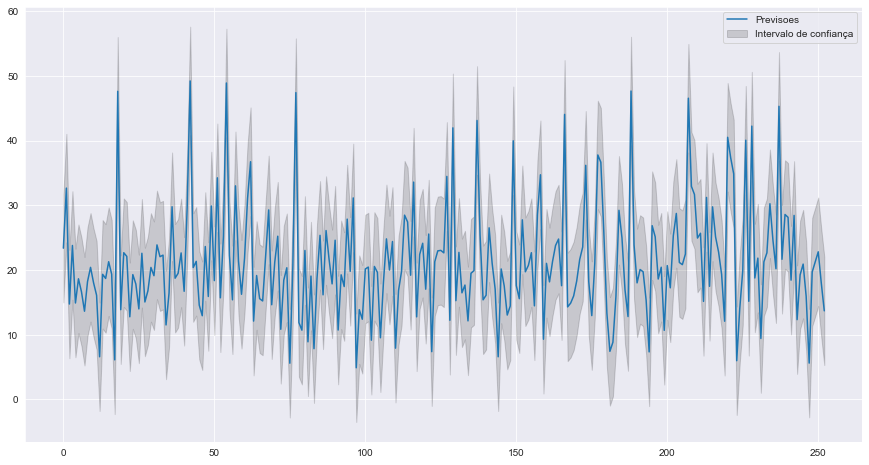

In [8]:
plt.rcParams["figure.figsize"] = (15,8)
sns.set_style("darkgrid", {'axes.grid' : True})
ind=[i for i in range(N)]
plt.plot(ind,f,label='Previsoes')

plt.fill_between(ind,f-q_yhat,f+q_yhat,
                 color='k', alpha=.15,label='Intervalo de confiança')
plt.legend()
plt.show()

In [9]:
print(2*q_yhat)

16.76555169146994


In [10]:
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [11]:
def QuantileRegressionModel(dim,qs=[0.1, 0.5, 0.9]):
    ipt_layer = Input((dim,))
    layer1 = Dense(100, activation='relu')(ipt_layer)
    layer2 = Dense(100, activation='relu')(layer1)
    
    out1 = Dense(1, name='out1')(layer2)
    out2 = Dense(1, name='out2')(layer2)
    out3 = Dense(1, name='out3')(layer2)
    
    q1, q2, q3 = qs
    model = Model(inputs=ipt_layer, outputs=[out1, out2, out3])
    model.compile(loss={'out1': lambda y,f: tilted_loss(q1,y,f),
                        'out2': lambda y,f: tilted_loss(q2,y,f),
                        'out3': lambda y,f: tilted_loss(q3,y,f),}, 
                  loss_weights={'out1': 1, 'out2': 1, 'out3': 1},
                 optimizer='adam')
    
    return model

In [12]:
qs=[alpha/2, 0.5,1-alpha/2]
model=QuantileRegressionModel(X_train.shape[1],qs=qs)
model.fit(X_train,y_train, epochs=1000, batch_size=32, verbose=0)

In [13]:
forecast=model.predict(X_test)

In [14]:
lower_bound=forecast[0].flatten()
upper_bound=forecast[2].flatten()
print('Coverage of {}'.format(calculate_coverage(lower_bound,upper_bound,y_test)))

Coverage of 0.8023715415019763


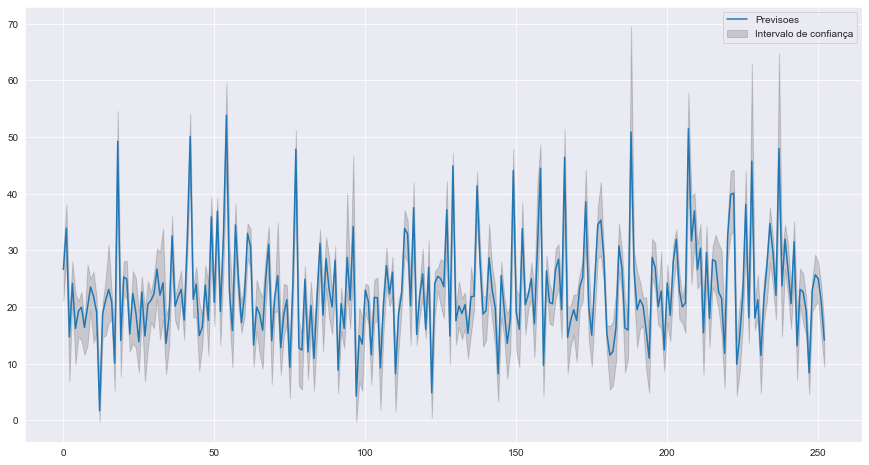

In [15]:
ind=[i for i in range(len(forecast[1].flatten()))]
plt.plot(ind,forecast[1].flatten(),label='Previsoes')

plt.fill_between(ind,lower_bound,upper_bound,
                 color='k', alpha=.15,label='Intervalo de confiança')
plt.legend()
plt.show()

(array([24., 71., 73., 42., 30.,  7.,  2.,  1.,  0.,  3.]),
 array([ 2.9656792,  5.2555943,  7.5455093,  9.835424 , 12.1253395,
        14.415255 , 16.70517  , 18.995085 , 21.285    , 23.574915 ,
        25.86483  ], dtype=float32),
 <BarContainer object of 10 artists>)

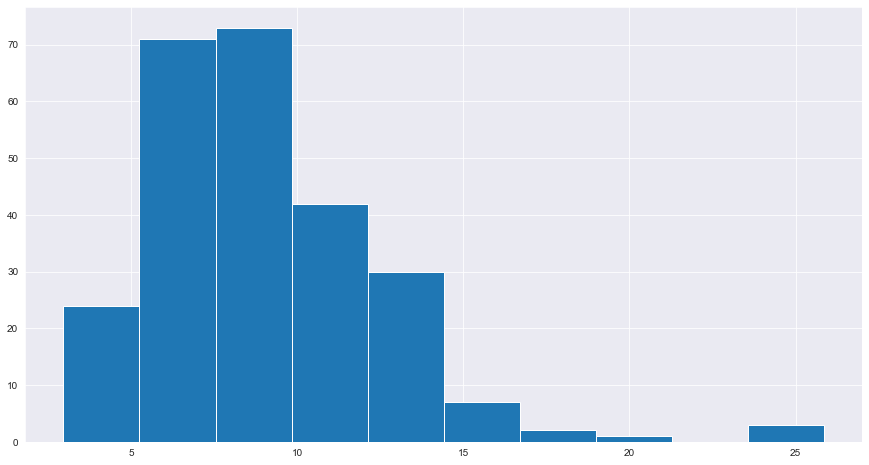

In [16]:
plt.hist(np.abs(upper_bound-lower_bound))

### Calibration step

In [17]:
def calibrate_qyhat(y_true,lower_bound,upper_bound,alpha):
    
    N=len(y_true)
    s=np.amax([lower_bound-y_test,y_test-upper_bound],axis=0)
    q_yhat=np.quantile(s,np.ceil((N+1)*(1-alpha))/N)
    
    return q_yhat

q_yhat=calibrate_qyhat(y_test,lower_bound,upper_bound,alpha)
print(q_yhat)
print('Coverage of {}'.format(calculate_coverage(forecast[0]-q_yhat,forecast[2]+q_yhat,y_test)))

3.7967327615489137
Coverage of 0.9565217391304348


(array([24., 71., 73., 42., 30.,  7.,  2.,  1.,  0.,  3.]),
 array([10.559145, 12.84906 , 15.138975, 17.42889 , 19.718805, 22.00872 ,
        24.298634, 26.588549, 28.878464, 31.168379, 33.458294],
       dtype=float32),
 <BarContainer object of 10 artists>)

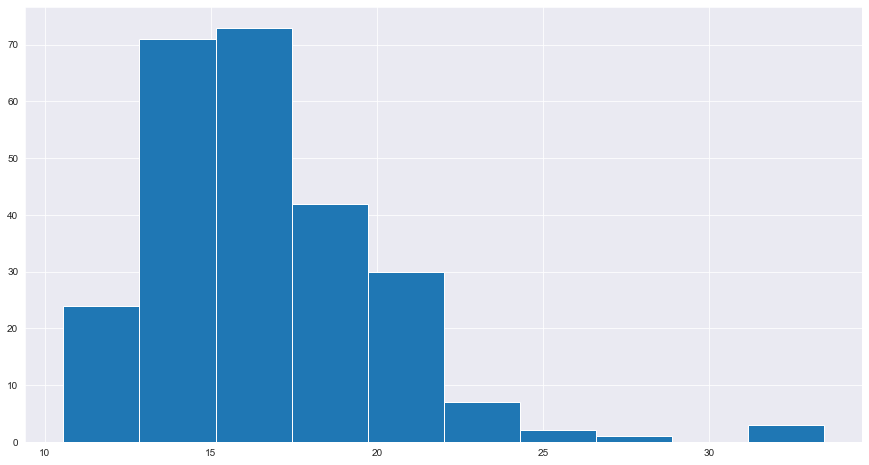

In [18]:
plt.hist(np.abs(upper_bound-lower_bound+2*q_yhat))

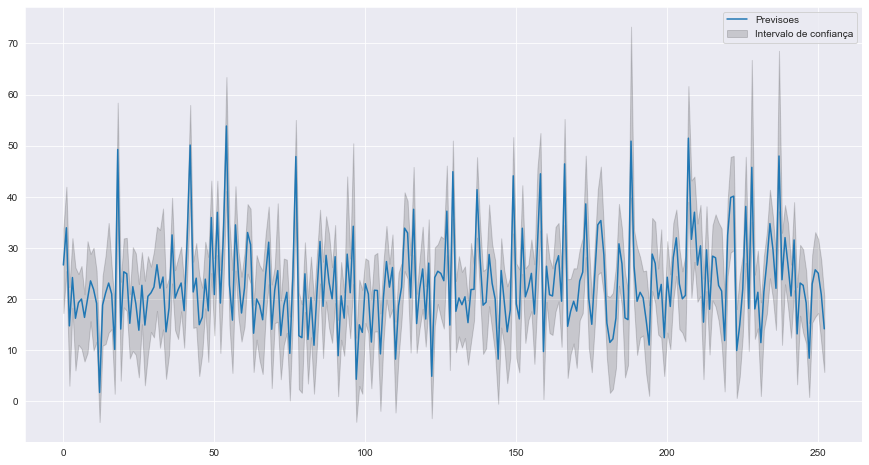

In [19]:
plt.plot(ind,forecast[1].flatten(),label='Previsoes')

plt.fill_between(ind,lower_bound-q_yhat,upper_bound+q_yhat,
                 color='k', alpha=.15,label='Intervalo de confiança')
plt.legend()
plt.show()

In [20]:
np.mean(upper_bound-lower_bound)+2*q_yhat

16.60156603274138

### Classification 

In [21]:
(X_train, y_train), (X_test,y_test) = tf.keras.datasets.cifar10.load_data()

In [22]:
y_train = y_train.reshape(-1,)
print(y_train.shape)
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

(50000,)


In [23]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

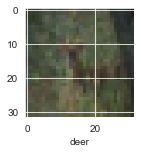

In [24]:
plot_sample(X_train, y_train,10)

In [25]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [26]:
X_cal,X_test,y_cal,y_test=train_test_split(X_test,y_test,test_size=0.5)

In [27]:
# Model Architecture
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)        

In [28]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [29]:
model.fit(X_train,y_train,batch_size=500,epochs=10)

Epoch 1/10
100/100 [==============================] - 18s 171ms/step - loss: 2.0051 - accuracy: 0.2507
Epoch 2/10
100/100 [==============================] - 17s 174ms/step - loss: 1.6867 - accuracy: 0.3769
Epoch 3/10
100/100 [==============================] - 18s 176ms/step - loss: 1.5686 - accuracy: 0.4224
Epoch 4/10
100/100 [==============================] - 19s 193ms/step - loss: 1.4936 - accuracy: 0.4485
Epoch 5/10
100/100 [==============================] - 18s 178ms/step - loss: 1.4352 - accuracy: 0.4729
Epoch 6/10
100/100 [==============================] - 18s 176ms/step - loss: 1.3945 - accuracy: 0.4911
Epoch 7/10
100/100 [==============================] - 18s 175ms/step - loss: 1.3603 - accuracy: 0.5030
Epoch 8/10
100/100 [==============================] - 18s 175ms/step - loss: 1.3210 - accuracy: 0.5202
Epoch 9/10
100/100 [==============================] - 18s 176ms/step - loss: 1.2917 - accuracy: 0.5290
Epoch 10/10
100/100 [==============================] - 18s 178ms/step - l

In [30]:
model.evaluate(X_test,y_test)

157/157 [==============================] - 1s 7ms/step - loss: 1.1338 - accuracy: 0.5966


[1.1338386535644531, 0.5965999960899353]

### Density based 

In [31]:

alpha=0.05
y_pred = model.predict(X_cal)
y_classes = [np.argmax(element) for element in y_pred]
N=X_cal.shape[0]

def get_ind(y_pred_i,y_test_i):
    return np.where(np.sort(y_pred_i)[::-1]==y_pred_i[y_test_i])[0][0]

def calculate_qyhat_classification(model,X_cal,y_cal,alpha=0.05):
    y_pred = model.predict(X_cal)
    sums_density=[]
    N=y_cal.shape[0]
    
    for i in range(N):
        sum_density=0
        ind=get_ind(y_pred[i],y_cal[i])
        sums_density.append(np.sum(np.sort(y_pred[i])[::-1][0:ind+1]))
        
    q_yhat=np.quantile(sums_density,np.ceil((N+1)*(1-alpha))/N)
    
    return q_yhat

def get_classes(model,X_test,q_yhat):
    
    y_pred = model.predict(X_test)
    
    classes_out=[]
    
    for i in range(y_pred.shape[0]):
        a=np.where(np.cumsum(np.sort(y_pred[i])[::-1])>q_yhat)[0][0]
        
        classes=[]
        
        for j in range(a+1):
            ind=np.where(y_pred==np.sort(y_pred[i])[::-1][j])[1][0]
            classes.append(ind)
        
        classes_out.append(classes)
        
    return classes_out

def calculate_coverage(conf_pred,y_true):
    s=0
    
    for i in range(len(conf_pred)):
        if y_true[i] in conf_pred[i]:
            s+=1
    
    return s/len(y_true)

In [32]:
q_yhat=calculate_qyhat_classification(model,X_cal,y_cal)
conf_pred=get_classes(model,X_test,q_yhat)

In [33]:
y_test=y_test.flatten()
y_cal=y_cal.flatten()
calculate_coverage(conf_pred,y_test)

0.9884

<BarContainer object of 10 artists>

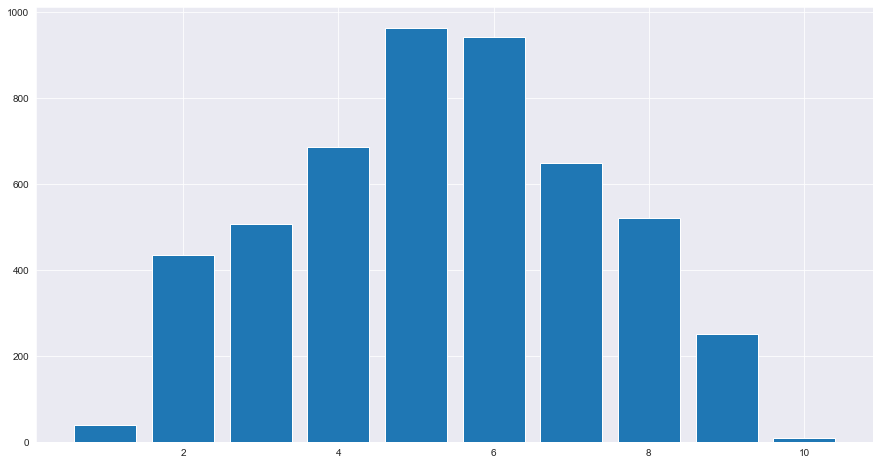

In [43]:
sets_dim=[len(set_conf) for set_conf in conf_pred]
plt.bar(dict(pd.Series(sets_dim).value_counts()).keys(),dict(pd.Series(sets_dim).value_counts()).values())

## Class-balanced conformal prediction

In [100]:
def Calculate_q_yhats(model,X_cal,alpha=0.05):
    y_pred = model.predict(X_cal)
    N=X_cal.shape[0]
    d_alpha={}
    d_alpha_q_yhats={}
    conf_pred=[]

    for i in range(N):
        real_class=y_cal[i]
        prob=1-y_pred[i][real_class]
        
        if real_class not in d_alpha:
            d_alpha[real_class]=[prob]
        else:
            d_alpha[real_class].append(prob)

    for i,(k,v) in enumerate(d_alpha.items()):
        N=len(v)
        d_alpha_q_yhats[k]=np.quantile(v,np.ceil((N+1)*(1-alpha))/N)
        
        
    return d_alpha_q_yhats

def ConformalPrediction_classbalanced(model,X_test,d_alpha_q_yhats):
    conf_pred=[]
    y_pred = model.predict(X_test)
    for i in range(y_pred.shape[0]):
        conf=[]
        for j in range(y_pred.shape[1]):
            if 1-y_pred[i][j]<d_alpha_q_yhats[j]:
                conf.append(j)
        conf_pred.append(conf)
        
    return conf_pred

In [101]:
d_alpha_q_yhats=Calculate_q_yhats(model,X_cal,alpha=0.05)
conf_pred=ConformalPrediction_classbalanced(model,X_test,d_alpha_q_yhats)
calculate_coverage(conf_pred,y_test)

0.9564

<BarContainer object of 10 artists>

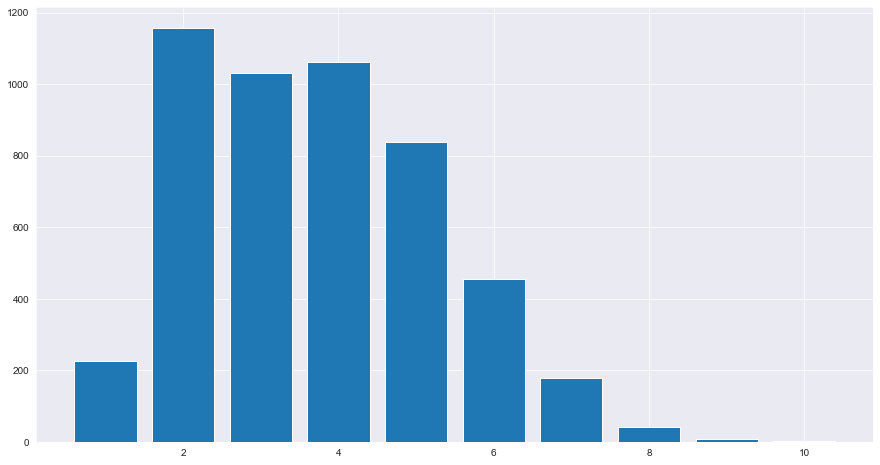

In [103]:
sets_dim=[len(set_conf) for set_conf in conf_pred]
plt.bar(dict(pd.Series(sets_dim).value_counts()).keys(),dict(pd.Series(sets_dim).value_counts()).values())